# The Relational Algebra in Python.


Copyright Jens Dittrich & Marcel Maltry, [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

### Imports

In [1]:
from graphviz import Digraph, Source
from ra.relation import Relation
from ra.schema_utils import build_schema

# https://docs.python.org/3.7/library/operator.html
# used here to be able to use certain built-in python operators as function parameters
import operator  

# Abstract classes for relational operators

In [2]:
class Operator:    
    """Abstract base class for an operator in an operator tree."""
    
    def __init__(self):
        """Initializes a new Operator object."""
        pass
    
    def __str__(self):
        """Returns a string representation of the subtree rooted in the operator node."""
        pass
    
    def get_graph(self, print_source=False):
        """Computes a `graphviz.Digraph` of the operator and all its children."""
        graph = Digraph(engine='circo')
        self._dot(graph, '')
        if print_source:
            print(graph)
        graph.graph_attr['rankdir'] = 'BT'  # display graph bottom-up
        return graph
    
    def evaluate(self):
        """Returns a `Relation` object representing the result of the operator.
        Note:
            Inner nodes also call `evaluate` on their childern to receive evaluated inputs.
        
        Returns:
            A `Relation` object representing the result after evaluating  the operator.
        """
        pass
    
    def _dot(self, graph, prefix):
        """Adds a node representing the operator to the graph.
        Note:
            Inner nodes also call `dot` on their children and add edges
            
        Args:
            graph (:obj: graphviz.Digraph): The graph a node is added to.
            prefix (:obj: `str`): The prefix for the unique identifier name, here path to the node.
            
        Returns:
            The name of the node added, s.t. parents can add edges from the inserted node.
        """
        pass
    
    
    def close(self):
        """Cleans up resources used by this operator. Rarely useful and/or required in Python
        """
        pass
    
class UnaryOperator(Operator):
    """Abstract base class for an internal node performing a unary operation.
    
    Attributes:
        input (:obj: `Operator`): The input to the unary operator
    """
    def __init__(self, input):
        self.input = input
    
    def _dot_helper(self, graph, prefix, name, label):
        """Helper for adding the node to the dot graph by perfoming common actions."""
        # add node to graph
        graph.node(name, label)
        # recursively add subtree to graph
        child_name = self.input._dot(graph, prefix+'I')
        # add edge from child to this node
        graph.edge(child_name, name)
        
    def close(self):
        self.input.close()
        
class BinaryOperator(Operator):
    """Abstract base class for an internal node performing a binary operation.
    
    Attributes:
        l_input (:obj: Operator): The left input to the binary operator.
        r_input (:obj: Operator): The right input to the binary operator.
    """
    def __init__(self, l_input, r_input):
        self.l_input = l_input
        self.r_input = r_input
    
    def _dot_helper(self, graph, prefix, name, label):
        """Helper for adding the node to the dot graph by perfoming common actions."""
        # add node to graph
        graph.node(name, label)
        # recursively add subtree to graph
        l_child_name = self.l_input._dot(graph, prefix+'L')
        r_child_name = self.r_input._dot(graph, prefix+'R')
        # add edge from child to this node
        graph.edge(l_child_name, name)
        graph.edge(r_child_name, name)

    def close(self):
        self.l_input.close()
        self.r_input.close()
        

class SetOperator(BinaryOperator):
    """Generic class for an internal node performing a set operation.
    
    Attributes:
        l_input (:obj: Operator): The left input to the binary operator.
        r_input (:obj: Operator): The right input to the binary operator.
        operator (function): The set operator as function from the operator module
        symbol (:obj: `str`): The symbol representig the set operation.
    """
    def __init__(self, l_input, r_input, operator, symbol):
        super().__init__(l_input, r_input)
        self.operator = operator
        self.symbol = symbol
    
    def __str__(self):
        return "({}) {} ({})".format(self.l_input, self.symbol, self.r_input)
    
    def evaluate(self):
        """Performs a set operation on its inputs."""
        # evaluate child nodes
        l_eval_input = self.l_input.evaluate()
        r_eval_input = self.r_input.evaluate()
        # integrity checks (attributes and domains must be identical)
        assert l_eval_input.attributes == r_eval_input.attributes
        assert l_eval_input.domains == r_eval_input.domains
        # create empty new relation
        new_schema = build_schema(l_eval_input.attributes, l_eval_input.domains)
        new_relation = Relation("Result", new_schema)
        # add tuples to new relation
        for tup in self.operator(l_eval_input.tuples, r_eval_input.tuples):
            new_relation.add_tuple(tup)
        return new_relation         
        
    def _dot(self, graph, prefix):
        # build name and label and call helper function
        node_name = prefix + 'SOp'
        node_label = self.symbol
        self._dot_helper(graph, prefix, node_name, node_label)
        return node_name    

        
class LeafOperator(Operator):
    """Abstract base class for a leaf node of an operator tree."""
    pass

# Relation

### Implementation

In [3]:
class LeafRelation(LeafOperator):
    """Leaf operator wrapping an input relation.
    
    Attributes:
        relation (:obj: `Relation`): The relation held by the leaf operator.
    """
    def __init__(self, relation):
        self.relation = relation
        
    def __str__(self):
        return self.relation.name
    
    def evaluate(self):
        """Evaluates the operator by returning the relation held by the leaf node."""
        return self.relation
    
    def _dot(self, graph, prefix):
        node_name = prefix + 'Rel'
        node_label = self.relation.name
        graph.node(node_name, node_label)
        return node_name

### Application

In [4]:
from os import listdir

# Data source: https://relational.fit.cvut.cz/dataset/IMDb
# Information courtesy of IMDb (http://www.imdb.com). Used with permission.
# Notice: The data can only be used for personal and non-commercial use and must not
# be altered/republished/resold/repurposed to create any kind of online/offline
# database of movie information (except for individual personal use).

path = 'data/IMDb_sample'  
# create a list of all files in that directory that end with "*.csv":
files = [file for file in listdir(path) if file.endswith('.csv')]

from ra.csv_utils import load_csv

relations = [load_csv(path + '/' + file, file[:-4], delimiter='\t') for file in files]

relationsDict = {}
for rel in relations:
    relationsDict[rel.name] = rel
print(relationsDict)

{'movies_directors': <ra.relation.Relation object at 0x11d195c18>, 'actors': <ra.relation.Relation object at 0x11d195cf8>, 'directors': <ra.relation.Relation object at 0x11d1fd7f0>, 'movies_genres': <ra.relation.Relation object at 0x11d1fd940>, 'directors_genres': <ra.relation.Relation object at 0x11d200ba8>, 'movies': <ra.relation.Relation object at 0x11d204320>, 'roles': <ra.relation.Relation object at 0x11d204278>}


In [5]:
# build LeafRelation object from relations dictionary
movies_directors = LeafRelation(relationsDict['movies_directors'])
actors = LeafRelation(relationsDict['actors'])
directors = LeafRelation(relationsDict['directors'])
movies_genres = LeafRelation(relationsDict['movies_genres'])
directors_genres = LeafRelation(relationsDict['directors_genres'])
movies = LeafRelation(relationsDict['movies'])
roles = LeafRelation(relationsDict['roles'])

In [6]:
directors.evaluate().print_set()

[directors] : {[ id:int, first_name:str, last_name:str ]}
{
	(43095, Stanley, Kubrick),
	(11652, James (I), Cameron),
	(78273, Quentin, Tarantino)
}


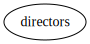

In [7]:
graph = directors.get_graph()
Source(graph)

# Selection

### Implementation

In [8]:
class Selection(UnaryOperator):
    """The relational selection:
        
    Attributes:    
        input (:obj: `Operator`): The input to the selection operator.
        predicate (:obj: `str`): The predicate to be evaluated by the selection on its input.
    """
    def __init__(self, input, predicate):
        super().__init__(input)
        self.predicate = predicate
        
    def __str__(self):
        return "σ_[{}]({})".format(self.predicate, self.input)
    
    def evaluate(self):
        """Performs the selection by evaluating the predicate on its input."""
        # evaluate child node
        eval_input = self.input.evaluate()
        # build empty relation with same schema as input
        new_schema = build_schema(eval_input.attributes, eval_input.domains)
        new_relation = Relation("Result", new_schema)
        # check predicate for each tuple in input
        for tup in eval_input.tuples:
            # evaluate predicate for given tup using eval
            if eval(self.predicate, Selection._locals_dict(tup, eval_input.attributes)):
                new_relation.add_tuple(tup)  # implicitly handles duplicate elimination
        return new_relation
    
    def _dot(self, graph, prefix):
        # build name and label and call helper function
        node_name = prefix + 'Sel'
        node_label = "σ_[{}]".format(self.predicate)
        self._dot_helper(graph, prefix, node_name, node_label)
        return node_name
    
    @staticmethod
    def _locals_dict(tup, attributes):
        """
        Builds a dictionary mapping the attribute names to the corresponding value in the tuple for use in `eval`

        Args:
            tup (`tuple`): The tuple of values.
            attributes(`list` of :obj: `string`): The attribute names
        
        Returns:
            A dictionary mapping attribute names to tuple values
        """
        # build dictionary
        return {attr: val for attr, val in zip(attributes, tup)}

### Application

In [9]:
newmovies =  Selection(movies, 'year>2000')

In [10]:
print(newmovies)

σ_[year>2000](movies)


In [11]:
newmovies.evaluate().print_set()

[Result] : {[ id:int, name:str, year:int, rank:float ]}
{
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(176712, Kill Bill: Vol. 2, 2004, 8.2),
	(96779, Earthship.TV, 2001, 5.6),
	(105938, Expedition: Bismarck, 2002, 7.5),
	(159665, Inglorious Bastards, 2006, 8.3),
	(393538, Jimmy Kimmel Live!, 2003, 6.7),
	(10934, Aliens of the Deep, 2005, 6.5)
}


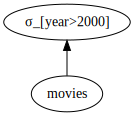

In [12]:
graph = newmovies.get_graph()
Source(graph)

# Projection

### Implementation

In [13]:
class Projection(UnaryOperator):
    """"The relational projection:
        
    Attributes:    
        input (:obj: `Operator`): The input to the projection operator.
        attributes (`list` of :obj: `str`): The names of the attributes the input is projected on.
    """
    def __init__(self, input, attributes):
        super().__init__(input)
        self.attributes = attributes
        
    def __str__(self):
        return "π_{}({})".format(self.attributes, self.input)
    
    def evaluate(self):
        """Performs the projection."""
        # evaluate child node
        eval_input = self.input.evaluate()
        # build new empty relation with the projected attributes
        new_schema = build_schema(self.attributes, [*map(eval_input.get_attribute_domain, self.attributes)])
        new_relation = Relation("Result", new_schema)
        # add tuples to new relation
        attr_indexes = [*map(eval_input.get_attribute_index, self.attributes)]
        for tup in eval_input.tuples:
            new_tup = tuple(tup[i] for i in attr_indexes)
            new_relation.add_tuple(new_tup)  # automatically eliminates duplicates
        return new_relation
    
    def _dot(self, graph, prefix):
        # build name and label and call helper function
        node_name = prefix + 'Pro'
        node_label = "π_{}".format(self.attributes)
        self._dot_helper(graph, prefix, node_name, node_label)
        return node_name

### Application

In [14]:
exp2 = Projection(newmovies, ['id', 'year'])

In [15]:
print(exp2)

π_['id', 'year'](σ_[year>2000](movies))


In [16]:
exp2.evaluate().print_set()

[Result] : {[ id:int, year:int ]}
{
	(96779, 2001),
	(393538, 2003),
	(176712, 2004),
	(176711, 2003),
	(127297, 2003),
	(159665, 2006),
	(105938, 2002),
	(10934, 2005)
}


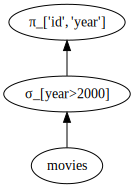

In [17]:
graph = exp2.get_graph()
Source(graph)

# Cartesian Product

### Implementation

In [18]:
class Cartesian_Product(BinaryOperator):
    """The relational cartesion product
    
    Attributes:
        l_input (:obj: `Operator`): The left input to the cartesian product operator.
        r_input (:obj: `Operator`): The right input to the cartesian product operator.
    """
    def __init__(self, l_input, r_input):
        super().__init__(l_input, r_input)
        
    def __str__(self):
        return "({}) × ({})".format(str(self.l_input), str(self.r_input))
    
    def evaluate(self):
        """Performs a cartesian product on its inputs."""
        # evaluate child nodes
        l_eval_input = self.l_input.evaluate()
        r_eval_input = self.r_input.evaluate()
        # integrity check (equally named attributes are not allowed here)
        assert len(set(l_eval_input.attributes) & set(r_eval_input.attributes)) == 0
        # create empty new relation
        new_schema = build_schema(l_eval_input.attributes+r_eval_input.attributes,
                                  l_eval_input.domains+r_eval_input.domains)
        new_relation = Relation("Result", new_schema)
        # insert cartesian product of tuples
        for tup1 in l_eval_input.tuples:
            for tup2 in r_eval_input.tuples:
                new_relation.add_tuple(tup1+tup2)
        return new_relation
    
    def _dot(self, graph, prefix):
        # build name and label and call helper function
        node_name = prefix + 'Car'
        node_label = "×"
        self._dot_helper(graph, prefix, node_name, node_label)
        return node_name

### Application

In [19]:
cartesianProduct = Cartesian_Product(directors, directors_genres)

In [20]:
print(cartesianProduct)

(directors) × (directors_genres)


In [21]:
directors.evaluate().print_set()

[directors] : {[ id:int, first_name:str, last_name:str ]}
{
	(43095, Stanley, Kubrick),
	(11652, James (I), Cameron),
	(78273, Quentin, Tarantino)
}


In [22]:
directors_genres.evaluate().print_set()

[directors_genres] : {[ director_id:int, genre:str, prob:float ]}
{
	(11652, Romance, 0.25),
	(43095, Music, 0.0625),
	(78273, Comedy, 0.25),
	(11652, Thriller, 0.416667),
	(43095, Adventure, 0.0625),
	(43095, Horror, 0.0625),
	(43095, Comedy, 0.125),
	(11652, Action, 0.5),
	(43095, Mystery, 0.0625),
	(78273, Romance, 0.125),
	(11652, Family, 0.0833333),
	(11652, Drama, 0.25),
	(43095, Action, 0.0625),
	(78273, Crime, 0.5),
	(78273, Drama, 0.75),
	(43095, War, 0.375),
	(43095, Film-Noir, 0.125),
	(43095, Drama, 0.625),
	(11652, Horror, 0.166667),
	(43095, Crime, 0.1875),
	(43095, Short, 0.1875),
	(78273, Action, 0.5),
	(11652, Documentary, 0.25),
	(78273, War, 0.125),
	(43095, Documentary, 0.1875),
	(78273, Thriller, 0.5),
	(11652, Comedy, 0.0833333),
	(11652, Adventure, 0.166667),
	(43095, Thriller, 0.1875),
	(11652, Sci-Fi, 0.5),
	(43095, Sci-Fi, 0.1875),
	(43095, Romance, 0.1875),
	(78273, Mystery, 0.125),
	(11652, Fantasy, 0.0833333),
	(11652, Short, 0.25)
}


In [23]:
len(directors_genres.evaluate()), len(directors.evaluate())

(35, 3)

In [24]:
print("number of expected tuples in cross product: ", len(directors_genres.evaluate())*len(directors.evaluate()))

number of expected tuples in cross product:  105


In [25]:
cartesianProduct.evaluate().print_set(10)

[Result] : {[ id:int, first_name:str, last_name:str, director_id:int, genre:str, prob:float ]}
{
	(78273, Quentin, Tarantino, 78273, Drama, 0.75),
	(78273, Quentin, Tarantino, 43095, Drama, 0.625),
	(78273, Quentin, Tarantino, 43095, Short, 0.1875),
	(78273, Quentin, Tarantino, 11652, Horror, 0.166667),
	(43095, Stanley, Kubrick, 11652, Drama, 0.25),
	(78273, Quentin, Tarantino, 43095, Action, 0.0625),
	(11652, James (I), Cameron, 78273, Thriller, 0.5),
	(43095, Stanley, Kubrick, 43095, Film-Noir, 0.125),
	(43095, Stanley, Kubrick, 43095, Adventure, 0.0625),
	(11652, James (I), Cameron, 11652, Short, 0.25)
}


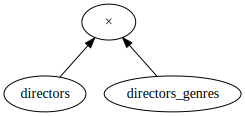

In [26]:
graph = cartesianProduct.get_graph()
Source(graph)

# Intersection

We use the generic `SetOperator` to compute the intersection of the sets of input tuples.

In [27]:
class Intersection(SetOperator):
    """The relational intersection operator
    
    Attributes:
        l_input (:obj: Operator): The left input to the binary operator.
        r_input (:obj: Operator): The right input to the binary operator.
    """
    def __init__(self, l_input, r_input):
        super().__init__(l_input, r_input, operator.and_, "∩")

### Application

In [28]:
goodmovies = Selection(movies, "rank>=7.5")
goodAndNew = Intersection(newmovies, goodmovies)

In [29]:
goodAndNew.evaluate().print_set()

[Result] : {[ id:int, name:str, year:int, rank:float ]}
{
	(105938, Expedition: Bismarck, 2002, 7.5),
	(176712, Kill Bill: Vol. 2, 2004, 8.2),
	(159665, Inglorious Bastards, 2006, 8.3),
	(176711, Kill Bill: Vol. 1, 2003, 8.4)
}


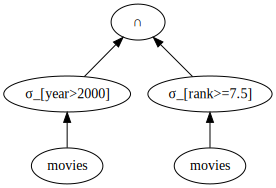

In [30]:
graph = goodAndNew.get_graph()
Source(graph)

Alternatively, without intersection but with two conditions in the selection instead:

In [31]:
goodAndNewSel = Selection(movies, "year>2000 and rank>=7.5")

In [32]:
goodAndNewSel.evaluate().print_set()

[Result] : {[ id:int, name:str, year:int, rank:float ]}
{
	(105938, Expedition: Bismarck, 2002, 7.5),
	(159665, Inglorious Bastards, 2006, 8.3),
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(176712, Kill Bill: Vol. 2, 2004, 8.2)
}


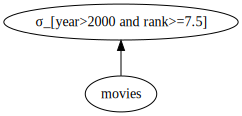

In [33]:
graph = goodAndNewSel.get_graph()
Source(graph)

# Union

We use the generic `SetOperator` to compute the union of the sets of input tuples.

In [34]:
class Union(SetOperator):
    """The relational union operator
    
    Attributes:
        l_input (:obj: Operator): The left input to the binary operator.
        r_input (:obj: Operator): The right input to the binary operator.
    """
    def __init__(self, l_input, r_input):
        super().__init__(l_input, r_input, operator.or_, "∪")

### Application

In [35]:
goodOrNew = Union(goodmovies, newmovies)

In [36]:
print(goodOrNew)

(σ_[rank>=7.5](movies)) ∪ (σ_[year>2000](movies))


In [37]:
goodOrNew.evaluate().print_set()

[Result] : {[ id:int, name:str, year:int, rank:float ]}
{
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(299073, Shining, The, 1980, 8.2),
	(387728, ER, 1994, 7.7),
	(328285, Terminator, The, 1984, 7.9),
	(177019, Killing, The, 1956, 8.1),
	(10934, Aliens of the Deep, 2005, 6.5),
	(164572, Jackie Brown, 1997, 7.5),
	(250612, Paths of Glory, 1957, 8.6),
	(276217, Reservoir Dogs, 1992, 8.3),
	(176712, Kill Bill: Vol. 2, 2004, 8.2),
	(96779, Earthship.TV, 2001, 5.6),
	(92616, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, 1964, 8.7),
	(193519, Lolita, 1962, 7.6),
	(310455, Spartacus, 1960, 8.0),
	(267038, Pulp Fiction, 1994, 8.7),
	(121538, Full Metal Jacket, 1987, 8.2),
	(1711, 2001: A Space Odyssey, 1968, 8.3),
	(10920, Aliens, 1986, 8.2),
	(328277, Terminator 2: Judgment Day, 1991, 8.1),
	(30431, Barry Lyndon, 1975, 7.9),
	(65764, Clockwork Orange, A, 1971, 8.3),
	(105938, Expedition: Bismarck, 2002, 7.5),
	(159665, Inglorio

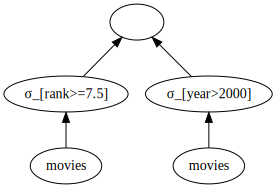

In [38]:
graph = goodOrNew.get_graph()
Source(graph)

Alternatively, without union but with two conditions in the selection instead.

In [39]:
goodOrNewSel = Selection(movies, "year>2000 or rank>=7.5")

In [40]:
print(goodOrNewSel)

σ_[year>2000 or rank>=7.5](movies)


In [41]:
goodOrNewSel.evaluate().print_set()

[Result] : {[ id:int, name:str, year:int, rank:float ]}
{
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(299073, Shining, The, 1980, 8.2),
	(387728, ER, 1994, 7.7),
	(328285, Terminator, The, 1984, 7.9),
	(177019, Killing, The, 1956, 8.1),
	(10934, Aliens of the Deep, 2005, 6.5),
	(164572, Jackie Brown, 1997, 7.5),
	(250612, Paths of Glory, 1957, 8.6),
	(276217, Reservoir Dogs, 1992, 8.3),
	(176712, Kill Bill: Vol. 2, 2004, 8.2),
	(96779, Earthship.TV, 2001, 5.6),
	(92616, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, 1964, 8.7),
	(193519, Lolita, 1962, 7.6),
	(310455, Spartacus, 1960, 8.0),
	(267038, Pulp Fiction, 1994, 8.7),
	(121538, Full Metal Jacket, 1987, 8.2),
	(1711, 2001: A Space Odyssey, 1968, 8.3),
	(10920, Aliens, 1986, 8.2),
	(328277, Terminator 2: Judgment Day, 1991, 8.1),
	(30431, Barry Lyndon, 1975, 7.9),
	(65764, Clockwork Orange, A, 1971, 8.3),
	(105938, Expedition: Bismarck, 2002, 7.5),
	(159665, Inglorio

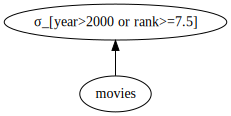

In [42]:
graph = goodOrNewSel.get_graph()
Source(graph)

# Difference

We use the generic `SetOperator` to compute the difference of the sets of input tuples.

In [43]:
class Difference(SetOperator):
    """The relational difference operator
    
    Attributes:
        l_input (:obj: Operator): The left input to the binary operator.
        r_input (:obj: Operator): The right input to the binary operator.
    """
    def __init__(self, l_input, r_input):
        super().__init__(l_input, r_input, operator.sub, "−")

### Application

In [44]:
newButBadMovies = Difference(newmovies, goodmovies)

In [45]:
print(newButBadMovies)

(σ_[year>2000](movies)) − (σ_[rank>=7.5](movies))


In [46]:
newButBadMovies.evaluate().print_set()

[Result] : {[ id:int, name:str, year:int, rank:float ]}
{
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(393538, Jimmy Kimmel Live!, 2003, 6.7),
	(10934, Aliens of the Deep, 2005, 6.5),
	(96779, Earthship.TV, 2001, 5.6)
}


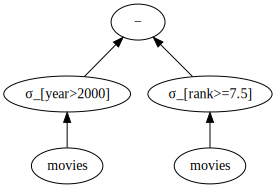

In [47]:
graph = newButBadMovies.get_graph()
Source(graph)

Alternatively, without intersection but with two conditions in the selection instead.

In [48]:
newButBadMoviesSel = Selection(movies, "year>2000 and not rank>=7.5")

In [49]:
newButBadMoviesSel.evaluate().print_set()

[Result] : {[ id:int, name:str, year:int, rank:float ]}
{
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(10934, Aliens of the Deep, 2005, 6.5),
	(393538, Jimmy Kimmel Live!, 2003, 6.7),
	(96779, Earthship.TV, 2001, 5.6)
}


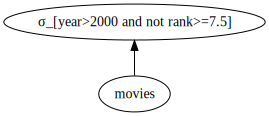

In [50]:
graph = newButBadMoviesSel.get_graph()
Source(graph)

# Renaming Relation

### Implementation

In [51]:
class Renaming_Relation(UnaryOperator):
    """"The renaming of a relation:
    
    Note:
        In our case renaming a relation isn't really powerful as we do not allow equal attribute names and,
        thus, dot-access (relation.attribute) is never required.
    
    Attributes:    
        input (:obj: `Operator`): The input to the renaming operator.
        name (:obj: `str`): The new name of the result relation.
    """
    def __init__(self, input, name):
        super().__init__(input)
        self.name = name
        
    def __str__(self):
        return "ρ_[{}]({})".format(self.name, self.input)
    
    def evaluate(self):
        """Performs the renaming."""
        # evaluate child node
        eval_input = self.input.evaluate()
        # integrity checks
        assert self.name.isidentifier()  # the name should be an identifier
        # build new empty relation and set name
        new_name = self.name
        new_schema = build_schema(eval_input.attributes, eval_input.domains)  # schema is left untouched
        new_relation = Relation(new_name, new_schema)
        # add all existing tuples
        for tup in eval_input.tuples:
            new_relation.add_tuple(tup)
        return new_relation
    
    def _dot(self, graph, prefix):
        # build name and label and call helper function
        node_name = prefix + 'ReR'
        node_label = "ρ_[{}]".format(self.name)
        self._dot_helper(graph, prefix, node_name, node_label)
        return node_name

### Application

In [52]:
exp11 = Renaming_Relation(goodOrNew, "good_or_new")

In [53]:
exp11.evaluate().print_set()

[good_or_new] : {[ id:int, name:str, year:int, rank:float ]}
{
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(299073, Shining, The, 1980, 8.2),
	(387728, ER, 1994, 7.7),
	(328285, Terminator, The, 1984, 7.9),
	(177019, Killing, The, 1956, 8.1),
	(10934, Aliens of the Deep, 2005, 6.5),
	(164572, Jackie Brown, 1997, 7.5),
	(250612, Paths of Glory, 1957, 8.6),
	(276217, Reservoir Dogs, 1992, 8.3),
	(176712, Kill Bill: Vol. 2, 2004, 8.2),
	(96779, Earthship.TV, 2001, 5.6),
	(92616, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, 1964, 8.7),
	(193519, Lolita, 1962, 7.6),
	(310455, Spartacus, 1960, 8.0),
	(267038, Pulp Fiction, 1994, 8.7),
	(121538, Full Metal Jacket, 1987, 8.2),
	(1711, 2001: A Space Odyssey, 1968, 8.3),
	(10920, Aliens, 1986, 8.2),
	(328277, Terminator 2: Judgment Day, 1991, 8.1),
	(30431, Barry Lyndon, 1975, 7.9),
	(65764, Clockwork Orange, A, 1971, 8.3),
	(105938, Expedition: Bismarck, 2002, 7.5),
	(159665, Ing

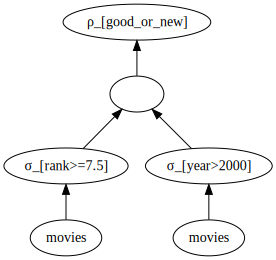

In [54]:
graph = exp11.get_graph()
Source(graph)

# Renaming Attributes

### Implementation

In [55]:
class Renaming_Attributes(UnaryOperator):
    """"The renaming of attributes of a relation:
    
    Note:
        In our case renaming a relation isn't really powerful as we do not allow equal attribute names and,
        thus, dot-access (relation.attribute) is never required.
    
    Attributes:    
        input (:obj: `Operator`): The input to the renaming operator.
        changes (`list` of :obj: `string`): List of changes of the form 'new_name<-old_name'.
    """
    def __init__(self, input, changes):
        super().__init__(input)
        self.changes = changes
        
    def __str__(self):
        return "ρ_{}({})".format(self.changes, self.input)
    
    def evaluate(self):
        """Performs the renaming."""
        # evaluate child node
        eval_input = self.input.evaluate()
        # build new empty relation and parse changes
        new_attributes = eval_input.attributes
        # apply each change to the attribute names
        for expr in self.changes:
            new_attributes = Renaming_Attributes._parse_attribute_rename(expr, new_attributes)
        new_schema = build_schema(new_attributes, eval_input.domains)
        new_relation = Relation("Result", new_schema)
        # add all existing tuples
        for tup in eval_input.tuples:
            new_relation.add_tuple(tup)
        return new_relation
    
    def _dot(self, graph, prefix):
        # build name and label and call helper function
        node_name = prefix + 'ReA'
        node_label = "ρ_{}".format(self.changes)
        self._dot_helper(graph, prefix, node_name, node_label)
        return node_name
    
    @staticmethod
    def _parse_attribute_rename(expr, attributes):
        """
        Apply the name change to the attributes
        
        Args:
            expr (:obj: `string`): expression describing the change of the form 'new_name<-old_name'
            attributes (`tuple` of :obj: `string`): the list of attributes that the change is to be applied to
        
        Returns:
            A list of attributes with the change applied.
        """
        split = expr.split('<-')
        # integrity checks
        assert len(split) == 2  # after the split there should just be an old name and a new one
        assert all(map(lambda x: x.isidentifier(), split))  # the attribute names should be identifiers
        # parse expression
        old_attr = split[1]
        new_attr = split[0]
        tmp_attributes = list(attributes)  # tuple do not allow item assignment
        for i, attr in enumerate(tmp_attributes):
            if attr == old_attr:
                tmp_attributes[i] = new_attr
                return tuple(tmp_attributes)
        raise ValueError

### Application

In [56]:
exp12 = Renaming_Attributes(exp11, ["movies<-name","published<-year"])

In [57]:
exp12.evaluate().print_set(10)

[Result] : {[ id:int, movies:str, published:int, rank:float ]}
{
	(127297, Ghosts of the Abyss, 2003, 6.7),
	(176711, Kill Bill: Vol. 1, 2003, 8.4),
	(299073, Shining, The, 1980, 8.2),
	(387728, ER, 1994, 7.7),
	(328285, Terminator, The, 1984, 7.9),
	(177019, Killing, The, 1956, 8.1),
	(10934, Aliens of the Deep, 2005, 6.5),
	(164572, Jackie Brown, 1997, 7.5),
	(250612, Paths of Glory, 1957, 8.6),
	(276217, Reservoir Dogs, 1992, 8.3)
}


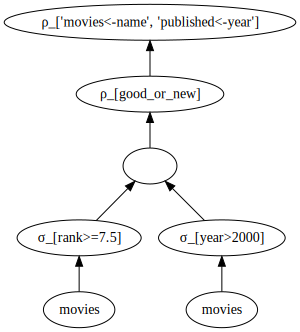

In [58]:
graph = exp12.get_graph()
Source(graph)

# Theta Join

### Implementation

In [59]:
class Theta_Join(BinaryOperator):
    """The relational theta join
    
    Note:
        We implemented the theta join as a combination of cartesian product, selection, and renaming.
    
    Attributes:
        l_input (:obj: `Operator`): The left input to the difference operator.
        r_input (:obj: `Operator`): The right input to the difference operator.
        theta (:obj: `string`): The join predicate.
    """
    def __init__(self, l_input, r_input, theta):
        super().__init__(l_input, r_input)
        self.theta = theta
        
    def __str__(self):
        return "({}) ⋈_[{}] ({})".format(self.l_input, self.theta, self.r_input)
    
    def evaluate(self):
        """Performs a theta join on its inputs."""
        # cartesian product, then selection,
        # note that the following line has square complexity!
        cp = Cartesian_Product(self.l_input, self.r_input)
        se = Selection(cp, self.theta)
        # evaluate expression and set new name
        new_relation = se.evaluate()
        new_relation.set_name("Result")
        return new_relation
        
    def _dot(self, graph, prefix):
        # build name and label and call helper function
        node_name = prefix + 'Joi'
        node_label = "⋈_[{}]".format(self.theta)
        self._dot_helper(graph, prefix, node_name, node_label)
        return node_name

### Application

In [60]:
directorsAndTheirMovies = Theta_Join(directors, movies_directors, "id==director_id")

In [61]:
directorsAndTheirMovies.evaluate().print_set(10)

[Result] : {[ id:int, first_name:str, last_name:str, director_id:int, movie_id:int ]}
{
	(78273, Quentin, Tarantino, 78273, 223710),
	(11652, James (I), Cameron, 11652, 340799),
	(11652, James (I), Cameron, 11652, 10934),
	(43095, Stanley, Kubrick, 43095, 299073),
	(43095, Stanley, Kubrick, 43095, 106666),
	(11652, James (I), Cameron, 11652, 328277),
	(43095, Stanley, Kubrick, 43095, 177019),
	(11652, James (I), Cameron, 11652, 96779),
	(43095, Stanley, Kubrick, 43095, 176891),
	(43095, Stanley, Kubrick, 43095, 65764)
}


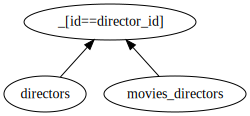

In [62]:
graph = directorsAndTheirMovies.get_graph()
Source(graph)

# Exercise: Equi-Join

### Implementation

In [63]:
class Equi_Join(BinaryOperator):
    """The relational equi join
    
    Attributes:
        l_input (:obj: `Operator`): The left input to the difference operator.
        r_input (:obj: `Operator`): The right input to the difference operator.
        ... [this is up to you] ...
    """
    def __init__(self, l_input, r_input, l_attrs, r_attrs):
        # here l_attrs and r_attrs are lists of attribute names
        super().__init__(l_input, r_input)
        # add your code here!
        # ...
        # initialize data structures that are required to perform the equi join.
    
    def __str__(self):
        # add your code here!
        # ...
        # return a string representation of the equi join.
        # use the lecture slides and implementations above to guide you!
        pass
    
    def evaluate(self):
        # add your code here!
        # ...
        # do not use any other operators as subroutines!
        # make sure that your implementation is in O(n)
        # where n is the number of tuples in l_input and r_input.
        pass
    
    def _dot(self, graph, prefix):
        # add your code here!
        # ...
        # adds the required nodes and edges to the given graph.
        # use the helper functions and let the implementations above guide you!
        pass

### Testing

In [64]:
import unittest

class EquiJoinTest(unittest.TestCase):
    
    def test_evaluate(self):
        # set up two relations to join
        foo = Relation('foo', [('fid', int), ('name', str), ('bar_id', int)])
        foo.add_tuple( (1, 'first',  3) )
        foo.add_tuple( (2, 'second', 2) )
        foo.add_tuple( (3, 'third',  1) )
        foo.add_tuple( (4, 'fourth', 1) )
        rel_foo = LeafRelation(foo)
        
        bar = Relation('bar', [('bid', int), ('string', str), ('attr', int)])
        bar.add_tuple( (1, 'fourth',  42) )
        bar.add_tuple( (2, 'second',  99) )
        bar.add_tuple( (3, 'first',    0) )
        rel_bar = LeafRelation(bar)
        
        # join name=string
        with self.subTest(msg='name=string'):
            l_attrs=['name']
            r_attrs=['string']
            eq = Equi_Join(rel_foo, rel_bar, l_attrs, r_attrs)
            res = eq.evaluate()
            
            self.assertEqual(len(res), 3)  # result contains 2tuples
            self.assertEqual(len(list(res.tuples)[0]), 6)  # result tuples have 6 attributes
            self.assertTrue((2, 'second', 2, 2, 'second', 99) in res.tuples)
            self.assertTrue((1, 'first',  3, 3, 'first',   0) in res.tuples)
            self.assertTrue((4, 'fourth', 1, 1, 'fourth', 42) in res.tuples)
            
        # join bar_id=bid
        with self.subTest(msg='bar_id=bid'):
            l_attrs=['bar_id']
            r_attrs=['bid']
            eq = Equi_Join(rel_foo, rel_bar, l_attrs, r_attrs)
            res = eq.evaluate()
        
            self.assertEqual(len(res), 4)  # result contains 4 tuples
            self.assertEqual(len(list(res.tuples)[0]), 6)  # result tuples have 6 attributes
            self.assertTrue((1, 'first',  3, 3, 'first',   0) in res.tuples)
            self.assertTrue((2, 'second', 2, 2, 'second', 99) in res.tuples)
            self.assertTrue((3, 'third',  1, 1, 'fourth', 42) in res.tuples)
            self.assertTrue((4, 'fourth', 1, 1, 'fourth', 42) in res.tuples)
        
        # join bar_id=bid and name=string
        with self.subTest(msg='bar_id=bid and name=string'):
            l_attrs=['bar_id', 'name']
            r_attrs=['bid', 'string']
            eq = Equi_Join(rel_foo, rel_bar, l_attrs, r_attrs)
            res = eq.evaluate()
            
            self.assertEqual(len(res), 3)  # result contains 2tuples
            self.assertEqual(len(list(res.tuples)[0]), 6)  # result tuples have 6 attributes
            self.assertTrue((1, 'first',  3, 3, 'first',   0) in res.tuples)
            self.assertTrue((2, 'second', 2, 2, 'second', 99) in res.tuples)
            self.assertTrue((4, 'fourth', 1, 1, 'fourth', 42) in res.tuples)

In [65]:
# Run the unit test without shutting down the jupyter kernel
unittest.main(argv=['ignored', '-v'], verbosity=2, exit=False)

test_evaluate (__main__.EquiJoinTest) ... 
ERROR: test_evaluate (__main__.EquiJoinTest) [name=string]
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-64-c4f98ad3cf3d>", line 27, in test_evaluate
    self.assertEqual(len(res), 3)  # result contains 2tuples
TypeError: object of type 'NoneType' has no len()

ERROR: test_evaluate (__main__.EquiJoinTest) [bar_id=bid]
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-64-c4f98ad3cf3d>", line 40, in test_evaluate
    self.assertEqual(len(res), 4)  # result contains 4 tuples
TypeError: object of type 'NoneType' has no len()

ERROR: test_evaluate (__main__.EquiJoinTest) [bar_id=bid and name=string]
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-64-c4f98ad3cf3d>", line 54, in test_evaluate
    self.assertEqua

# Grouping

### Implementation

In [66]:
class Grouping(UnaryOperator):
    """The relational grouping with aggregation.

    Note:
        We only support builtin functions for aggregation, e.g. `sum`, `max`.

    Attributes:
        input (:obj: `Operator`): The input to the renaming operator.
        group_by (`list` of :obj: `string`): A list of attributes the input should be grouped by.
        aggregations (`list` of `tuple` of builtin function and :obj: `string`):
            A list of aggregates of the form (builtin function, attribute)
        builtin_to_str (`dict` of builtin function to :obj: `string`):
            Dict mapping builtin function to `string` represenation.
    """
    builtin_to_str = {sum: 'sum', max:'max', min:'min', len:'count'}

    def __init__(self, input, groups, aggregations=[]):
        super().__init__(input)
        self.group_by = groups
        self.aggregations = aggregations

    def __str__(self):
        aggr = ["{}({})".format(self.builtin_to_str[func], attr) for func, attr in self.aggregations]
        return "(γ_{} {} ({})".format(self.group_by, aggr, self.input)

    def evaluate(self):
        """Performs grouping and aggregation on its inputs."""
        # evaluate input
        eval_input = self.input.evaluate()
        # build groups
        groups = self._build_groups(eval_input)
        # compute aggregations
        tuples = self._compute_aggregations(eval_input, groups)
        # build new relation
        grp_schema = build_schema(self.group_by, [eval_input.get_attribute_domain(x) for x in self.group_by])
        agg_schema = [(self.builtin_to_str[agg[0]]+'_'+agg[1], int) for agg in self.aggregations]
        new_schema = grp_schema + agg_schema  # combine both schemas
        new_relation = Relation("Result", new_schema)
        # insert tuples into relation
        for tup in tuples:
            new_relation.add_tuple(tup)
        return new_relation

    def _dot(self, graph, prefix):
        # build name and label and call helper function
        node_name = prefix + 'Gro'
        aggr = ["{}({})".format(self.builtin_to_str[func], attr) for func, attr in self.aggregations]
        node_label = "γ_{} {}".format(self.group_by, aggr)
        self._dot_helper(graph, prefix, node_name, node_label)
        return node_name

    def _build_groups(self, eval_input):
        """Builds the groups from the evaluated input."""
        groups = dict()  # maps group to tuples in group
        idxs =  [eval_input.get_attribute_index(attr) for attr in self.group_by] # get indexes of attributes in group
        # insert each tuple in corresponding group
        for tup in eval_input.tuples:
            key = tuple(tup[i] for i in idxs)  # determine group of tuple
            group = groups.get(key, [])  # retrieve group from map, default: empty list
            groups[key] = group+[tup]  # add tuple to group
        return groups

    def _compute_aggregations(self, eval_input, groups):
        """Computes aggregations on partitioned groups."""
        results = set()  # result set of tuples, containing group attributes and aggregates
        # for each group, compute aggregates
        for key in groups:
            result_tup = key  # first part of result tuple is the group
            group = groups[key]  # get list of group members to compute aggregations on
            # compute each aggregate            
            for func, attr in self.aggregations:
                idx = eval_input.get_attribute_index(attr)  # position of attribute within each tuple
                agg_result = func([x[idx] for x in group])  # apply aggregation function to list of attributes
                result_tup += (agg_result, )  # append aggregation result to result tuple
            results.add(result_tup)
        return results

### Application

In [67]:
# Idea: count the number of female/male actors

# grouping key: ['gender']
# aggregation function: len (also called count)
# notice that for len() specifying an attribute is actually not required
# as only the number of tuples in each group are coiunted
# this is independent of a specific attribute value
grouping = Grouping(actors, ['gender'], [(len, 'id')])

In [68]:
print(grouping)

(γ_['gender'] ['count(id)'] (actors)


In [69]:
grouping.evaluate().print_set()

[Result] : {[ gender:str, count_id:int ]}
{
	(F, 289),
	(M, 802)
}


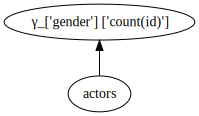

In [70]:
graph = grouping.get_graph()
Source(graph)

In [71]:
# Idea: count the number of movies per year
# also sum up the years in each group which
# does not make sense semantically, just done to
# show that one can use multiple aggregations in a Grouping

# grouping key: ['year']
# aggregation function: len (also called count)
# aggregation function: sum (also called count)
grouping = Grouping(movies, ['year'], [(len, 'year'), (sum, 'id')])

In [72]:
grouping.evaluate().print_set()

[Result] : {[ year:int, count_year:int, sum_id:int ]}
{
	(1999, 1, 106666),
	(1953, 2, 402079),
	(1978, 1, 369522),
	(1964, 1, 92616),
	(2003, 3, 697546),
	(2002, 1, 105938),
	(1981, 1, 256530),
	(2001, 1, 96779),
	(1968, 1, 1711),
	(1957, 1, 250612),
	(1975, 1, 30431),
	(1994, 3, 995565),
	(2004, 1, 176712),
	(1951, 2, 196085),
	(1995, 1, 118367),
	(2000, 1, 385710),
	(2006, 1, 159665),
	(1992, 1, 276217),
	(1997, 2, 498428),
	(1991, 1, 328277),
	(1986, 1, 10920),
	(1962, 1, 193519),
	(1960, 1, 310455),
	(1984, 1, 328285),
	(1971, 1, 65764),
	(1987, 2, 345248),
	(1996, 1, 322652),
	(2005, 1, 10934),
	(1956, 1, 177019),
	(1989, 1, 5306),
	(1955, 1, 176891),
	(1980, 1, 299073)
}
